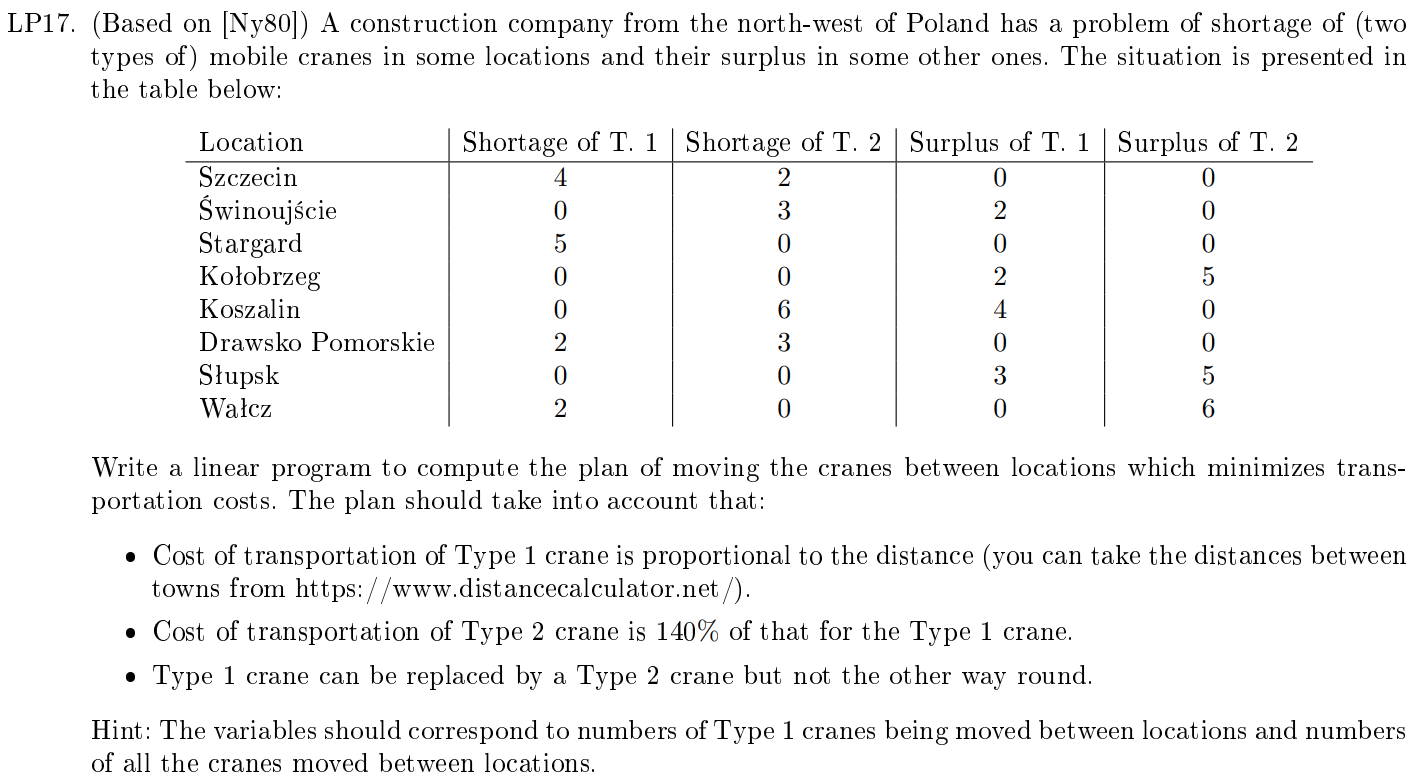

In [ ]:
import pulp

# Lokalizacje
locations = ["Szczecin", "Świnoujście", "Stargard", "Kołobrzeg", "Koszalin", "Drawsko Pomorskie", "Słupsk", "Wałcz"]

# Dystanse między miastami (w kilometrach)
distances = {
    ("Szczecin", "Świnoujście"): 57.94,
    ("Szczecin", "Stargard"): 34.68,
    ("Szczecin", "Kołobrzeg"): 108.96,
    ("Szczecin", "Koszalin"): 138.23,
    ("Szczecin", "Drawsko Pomorskie"): 85.46,
    ("Szczecin", "Słupsk"): 200.77,
    ("Szczecin", "Wałcz"): 129.66,
    
    ("Kołobrzeg", "Świnoujście"): 91.20 ,
    ("Kołobrzeg", "Stargard"): 99.91,
    ("Kołobrzeg", "Koszalin"): 39.80,
    ("Kołobrzeg", "Drawsko Pomorskie"): 74.06,
    ("Kołobrzeg", "Słupsk"): 99.86,
    ("Kołobrzeg", "Wałcz"): 117.29,
    
    ("Koszalin", "Świnoujście"): 129.75,
    ("Koszalin", "Stargard"): 120.72,
    ("Koszalin", "Drawsko Pomorskie"): 77.24,
    ("Koszalin", "Słupsk"): 63.01, 
    ("Koszalin", "Wałcz"): 103.90,
    
    ("Świnoujście", "Stargard"): 82.03,
    ("Świnoujście", "Drawsko Pomorskie"): 110.88,
    ("Świnoujście", "Słupsk"): 191.06,
    ("Świnoujście", "Wałcz"): 162.79,
    
    ("Stargard", "Drawsko Pomorskie"): 55.28,
    ("Stargard", "Słupsk"): 180.74,
    ("Stargard", "Wałcz"): 95.41,
    
    ("Drawsko Pomorskie", "Słupsk"): 130.97,
    ("Drawsko Pomorskie", "Wałcz"): 52.47,
    
    ("Słupsk", "Wałcz"): 137.65
}

keys = list(distances.keys()).copy()

for key in keys:
    distances[(key[1], key[0])] = distances[key]

# surpluses and shortages
shortages = {
    "Szczecin": [4, 2],   # T.1: 4, T.2: 2
    "Świnoujście": [0, 3],
    "Stargard": [5, 0],
    "Kołobrzeg": [0, 0],
    "Koszalin": [0, 6],
    "Drawsko Pomorskie": [2, 3],
    "Słupsk": [0, 0],
    "Wałcz": [2, 0],
}

surpluses = {
    "Szczecin": [0, 0],
    "Świnoujście": [2, 0],
    "Stargard": [0, 0],
    "Kołobrzeg": [2, 5],
    "Koszalin": [4, 0],
    "Drawsko Pomorskie": [0, 0],
    "Słupsk": [3, 5],
    "Wałcz": [0, 6],
}


model = pulp.LpProblem("Crane_Transportation", pulp.LpMinimize)


x = {}
for i in locations:
    for j in locations:
        if i != j:
            x[(i, j, 1)] = pulp.LpVariable(f"x_{i}_{j}_1", lowBound=0, cat='Integer')
            x[(i, j, 2)] = pulp.LpVariable(f"x_{i}_{j}_2", lowBound=0, cat='Integer')


model += pulp.lpSum(
    distances.get((i, j), 0) * (x[(i, j, 1)] + 1.4 * x[(i, j, 2)])
    for i in locations for j in locations if i != j
)

# surpplus
for i in locations:
    model += pulp.lpSum(x[(i, j, 1)] for j in locations if i != j) <= surpluses[i][0], f"Surplus_T1_{i}"
    model += pulp.lpSum(x[(i, j, 2)] for j in locations if i != j) <= surpluses[i][1], f"Surplus_T2_{i}"

# shortages
for j in locations:
    model += (
        pulp.lpSum(x[(i, j, 1)] for i in locations if i != j) +
        pulp.lpSum(x[(i, j, 2)] for i in locations if i != j) >= shortages[j][0],
        f"Shortage_T1_{j}"
    )
    model += (
        pulp.lpSum(x[(i, j, 2)] for i in locations if i != j) >= shortages[j][1],
        f"Shortage_T2_{j}"
    )
    model += (
        pulp.lpSum(x[(i, j, 1)] for i in locations if i != j) +
        pulp.lpSum(x[(i, j, 2)] for i in locations if i != j) >= shortages[j][0] + shortages[j][1],
        f"Shortage_ALL_{j}"
    )


solver = pulp.PULP_CBC_CMD(msg=True)
model.solve(solver)


print("Status:", pulp.LpStatus[model.status])
print("Minimal transportation cost:", pulp.value(model.objective))
for i, j, t in x:
    if pulp.value(x[(i, j, t)]) > 0:
        print(f"Number of cranes of the type {t} transportated from {i} to {j}: {pulp.value(x[(i, j, t)])}")


Status: Optimal
Minimal transportation cost: 2853.908
Number of cranes of the type 1 transportated from Świnoujście to Szczecin: 2.0
Number of cranes of the type 1 transportated from Kołobrzeg to Szczecin: 2.0
Number of cranes of the type 2 transportated from Kołobrzeg to Szczecin: 1.0
Number of cranes of the type 2 transportated from Kołobrzeg to Świnoujście: 3.0
Number of cranes of the type 2 transportated from Kołobrzeg to Koszalin: 1.0
Number of cranes of the type 1 transportated from Koszalin to Stargard: 4.0
Number of cranes of the type 1 transportated from Słupsk to Stargard: 1.0
Number of cranes of the type 2 transportated from Słupsk to Koszalin: 5.0
Number of cranes of the type 1 transportated from Słupsk to Wałcz: 2.0
Number of cranes of the type 2 transportated from Wałcz to Szczecin: 1.0
Number of cranes of the type 2 transportated from Wałcz to Drawsko Pomorskie: 5.0
